In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
# from torchvision.transforms import 
from tqdm import tqdm


In [5]:
batch_size = 4

#### Dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.Lambda(lambda t : (t*2)-1)
    ])

In [7]:
training_data = datasets.Flowers102(
    root="data",
    split='train',
    download=True,
    transform=transform
)
validation_data = datasets.Flowers102(
    root="data",
    split='val',
    download=True,
    transform=transform
)

test_data =  datasets.Flowers102(
    root="data",
    split='test',
    download=True,
    transform=transform
)

In [8]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [9]:
def show_image(img):
    # print("Shape of img [C, H, W]: ", img.shape)
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t : (t+1)/2),
        transforms.Lambda(lambda t : t.permute(1,2,0)), # Convert from CHW to HWC
        transforms.Lambda(lambda t : t*255.),
        transforms.Lambda(lambda t : t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
        ])
    # if len(img.shape) == 4:
    #     img = img[0, :, :, :]
    # print("After transform: Shape of img [C, H, W]: ", reverse_transform(img).shape)
    plt.imshow(reverse_transform(img))

In [10]:
loader_iter =iter(test_dataloader)

Shape of X [N, C, H, W]:  torch.Size([4, 3, 64, 64])


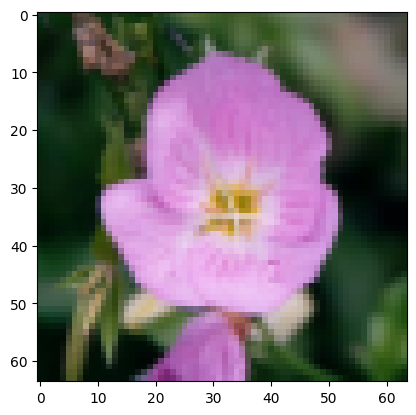

In [11]:
for X in next(loader_iter):
    print("Shape of X [N, C, H, W]: ", X.shape) 
    show_image(X[0])
    break

#### Formward diff

In [12]:
# Noise Scheduler
def noise_scheduler(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def get_value_at_timestep(values, t, x0_shape):
    batch_size = t.shape[0]
    values_at_t = values.gather(-1,t)   
    values = values_at_t.reshape(batch_size, *((1,) * (len(x0_shape) - 1))) 
    return values

# Forward diffusion
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alphas_hat = get_value_at_timestep(sqrt_alphas_cumprod, t, x0.shape)
    sqrt_one_minus_alphas_hat = get_value_at_timestep(
        sqrt_one_minus_alphas_cumprod, t, x0.shape
    )  
    diffused_image = sqrt_alphas_hat * x0 + sqrt_one_minus_alphas_hat * noise
    return diffused_image, noise
    
# Pre calucalte values for forward diffusion
T = 100
betas = noise_scheduler(T)
# print(betas)
alphas = 1 - betas
# print(alphas)
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.ones(1),alphas_cumprod[:-1]],dim=0) # [1.0] +alphas_cumprod[:-1]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

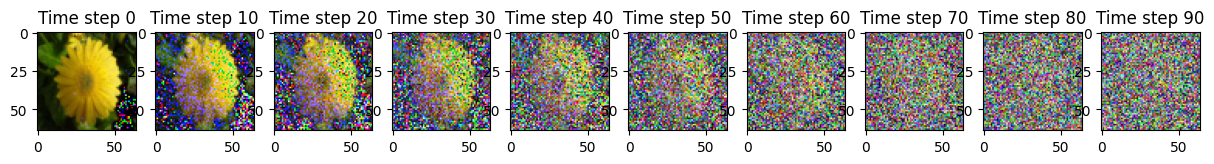

In [21]:
test_image = next(iter(train_dataloader))[0][0] # first img in first batch of train_dataloader

step_size = T//10
plt.figure(figsize=(15,15))
num_images = 10 # T/step_size
for i in range(0,T,step_size):
    t = torch.tensor([i])
    # print(t.shape)
    # print(t)
    diffused_image,noise = forward_diffusion(test_image, t)
    plt.subplot(1, num_images, int(i/step_size) + 1)
    plt.title(f'Time step {i}', fontsize=12)
    show_image(diffused_image)

#### Reverse 

##### Time Embedding

In [121]:
# class TimeEmbedding(nn.Module):
#     def __init__(self, embedding_dim=32):
#         super().__init__()
#         self.embedding = nn.Linear(1,embedding_dim)
#         self.rele = nn.ReLU()
#     def forward(self, t):
#         return self.relu(self.embedding(t))

In [22]:
import math

In [23]:
class TimeEmbedding(nn.Module):
    def __init__(self,time_emb_size=32, device = "cpu"):
        super().__init__()
        self.time_emb = time_emb_size
        self.device = device
    def forward(self, t):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, self.time_emb, 2, device=self.device).float() / self.time_emb)
        )
        embeddings = math.log(10000) / (self.time_emb // 2 - 1)
        embeddings = torch.exp(torch.arange(self.time_emb // 2, device=self.device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # print('embeddings.shape',embeddings.shape)
        return embeddings 

##### U-net block

In [24]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, t=32, sampling="down"):
        super().__init__()
        print('Channels:',in_channels, out_channels)    
        self.time_mlp = nn.Linear(t, out_channels)
        if sampling == 'down':
            # 2*in_channels because we will concat with residual inputs
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1) 
            self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.sampling = sampling

    def forward(self, x, t):
        time_emb = self.activation(self.time_mlp(t))[:,:, None, None]
        # print(time_emb.shape)
        h = self.activation(self.conv1(x))
        # if self.sampling == 'up':
            # print('Upsampling conv 1:',h.shape, time_emb.shape)
        # print(h.shape) # 
        h = h + time_emb
        h = self.activation(self.conv2(h))
        # if self.sampling == 'up':
        #     print('Upsampling conv 2:',h.shape)
        h = self.transform(h)
        # if self.sampling == 'up':
        #     print('Upsampling transform:',h.shape)
        return h
        # return self.activation(self.conv2(self.activation(self.conv1(x))))

In [25]:
block = Block(3, 64)
x = torch.randn(2,3,64,64)
t = torch.randn(2,32)
print(x.shape) # 
print(t.shape) # 
block(x,t).shape

Channels: 3 64
torch.Size([2, 3, 64, 64])
torch.Size([2, 32])


torch.Size([2, 64, 32, 32])

##### Encoder

In [26]:
class Encoder(nn.Module):
    def __init__(self, channels = [3, 64, 128, 256, 512, 1024], time_emb_size=32):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1], time_emb_size)  
                                         for i in range(len(channels)-1)
                                         ])
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x, time_emb):
        features = []
        for block in self.enc_blocks:
            x = block(x,time_emb)
            # features.append(x)
            # x = self.maxpool(x)
            features.append(x)
            # print(x.shape)
        # print('Encoeer Output:',x.shape)
        # return x
        return x, features

In [27]:
encoder = Encoder()

Channels: 3 64
Channels: 64 128
Channels: 128 256
Channels: 256 512
Channels: 512 1024


In [28]:
enc_x, residuals = encoder(x, t)

In [29]:
# print(residuals)

##### Decoder

In [30]:
class Decoder(nn.Module):
    def __init__(self, channels = [1024, 512, 256, 128, 64],time_emb_size=32):
        super().__init__()
        self.dec_blocks = nn.ModuleList([Block(channels[i], channels[i+1],time_emb_size, sampling="up")
                                         for i in range(len(channels)-1)])
        self.output = nn.ConvTranspose2d(channels[-1], 3, 4, 2, 1)
    def forward(self, x, time_emb, residuals):
        # print('[DEBUG] Decoder block...')
        # print(x.shape)
        for block in self.dec_blocks:
            residual = residuals.pop()
            # print('x.shape', x.shape)
            # print('residual.shape', residual.shape)
            # x = x + residual
            x = torch.cat((x, residual), dim=1)
            x = block(x, time_emb)
        # Predict noise
        x = self.output(x)
        # print('Decoder Output:',x.shape)
        return x
        

In [31]:
decoder = Decoder()

Channels: 1024 512
Channels: 512 256
Channels: 256 128
Channels: 128 64


In [32]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.time_emb = nn.Sequential(TimeEmbedding(),
                                      nn.ReLU())

    def forward(self, x, t):
        time_emb = self.time_emb(t)
        down_sampled_x, residuals = self.encoder(x, time_emb)
        return self.decoder(down_sampled_x, time_emb, residuals)

#### Training params

In [33]:
num_epochs = 100
loss = nn.L1Loss()
model = DDPM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
IMG_SIZE = 64
device = "cpu"

Channels: 3 64
Channels: 64 128
Channels: 128 256
Channels: 256 512
Channels: 512 1024
Channels: 1024 512
Channels: 512 256
Channels: 256 128
Channels: 128 64


#### Sampling

In [34]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_value_at_timestep(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_value_at_timestep(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_value_at_timestep(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_value_at_timestep(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_image(img[0].detach().cpu())
    plt.show()

Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])
Shape of img [C, H, W]:  torch.Size([3, 64, 64])


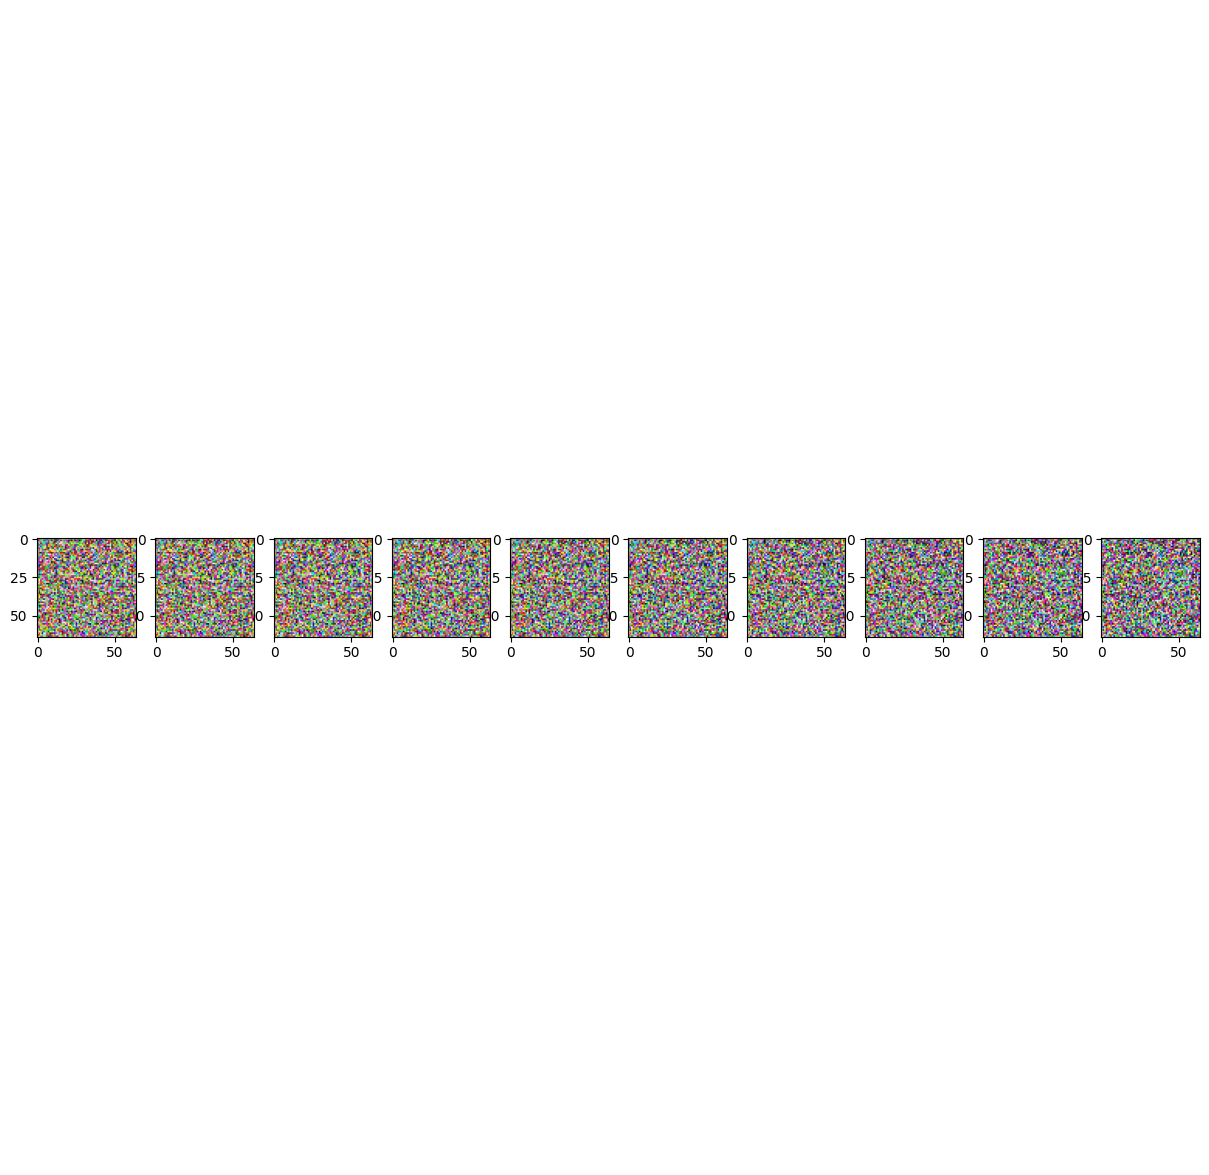

In [209]:

# sample_plot_image()

#### Training loop

Epoch 0 Loss: 0.800948441028595


<Figure size 1500x1500 with 0 Axes>

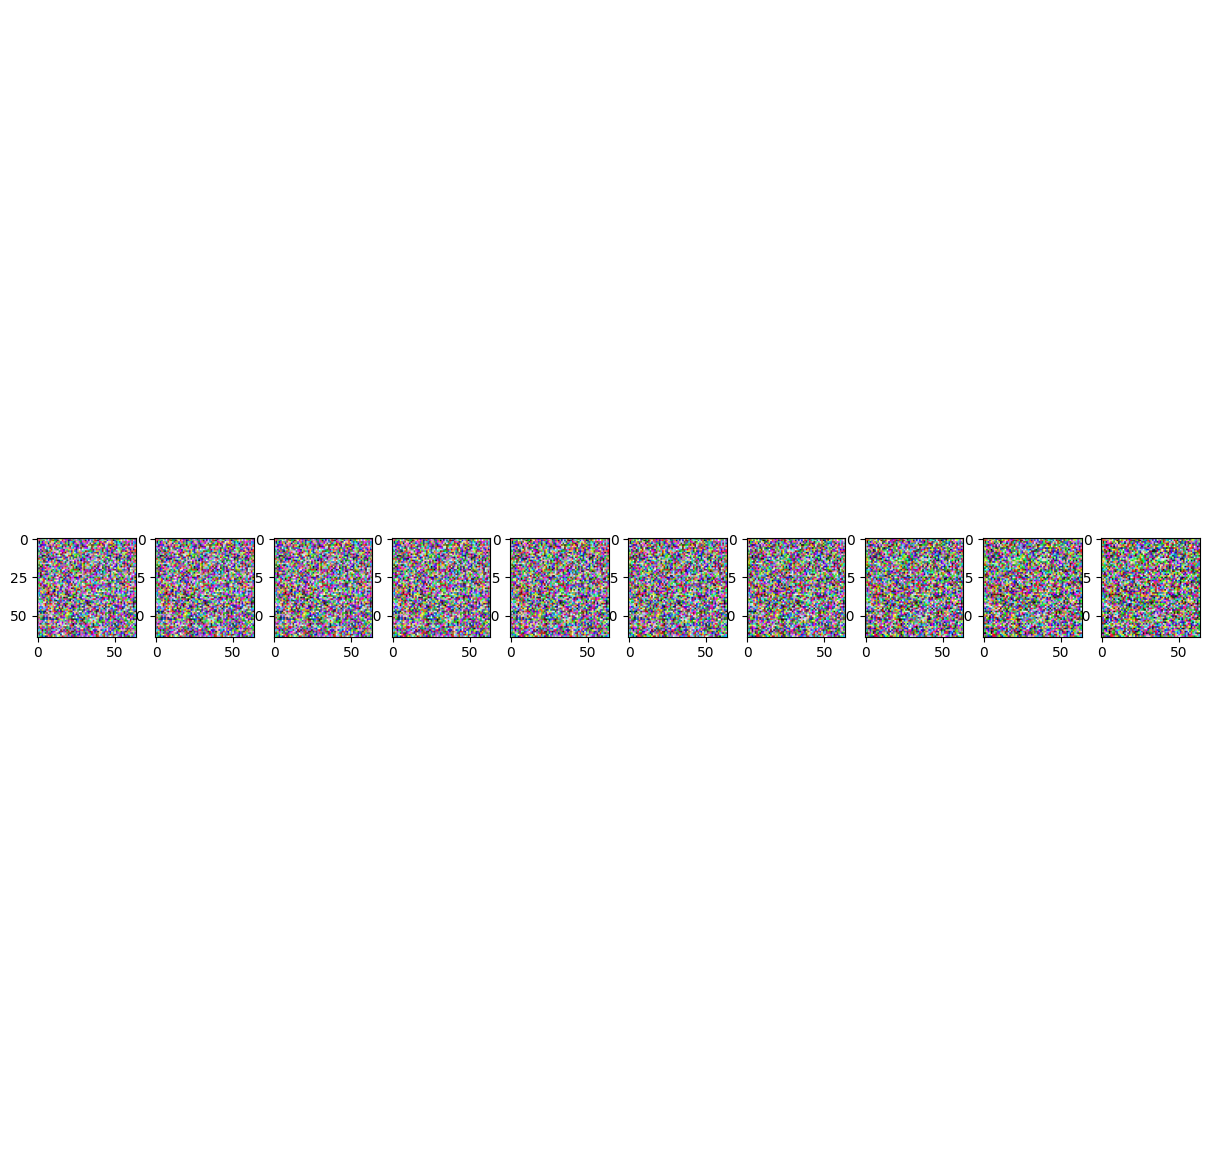

Epoch 1 Loss: 0.8007189631462097


Epoch 2:  14%|█▎        | 35/255 [00:07<00:48,  4.51it/s]

In [46]:
step_size = 1
plt.figure(figsize=(15,15))
num_images = num_epochs # T/step_size
epoch_loss = [] 
num_batches = len(train_dataloader)/batch_size
for epoch in range(num_epochs):
    loss = []
    # for x,_ in tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False):
    for batch_idx, (x,_) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False)):
        # print(x.shape)
        t = torch.randint(0, T, (batch_size,))
        # print(t.shape)
        # print(x.shape)
        diffused_image,noise = forward_diffusion(x, t)
        # t = torch.randint(0,T, (x.shape[0],))
        noise = torch.randn_like(x)
        # noise = model(t, noise, model)
        pred_noise = model(x, t)
        # print('pred_noise:',pred_noise.shape)
        # print('noise:',noise.shape)

        # loss.append((noise - pred_noise)**2)
        loss.append(F.l1_loss(noise, pred_noise))
        # print('Loss:',loss)
        if batch_idx % 4 == 0 or batch_idx == num_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # break
    print('Epoch {} Loss: {}'.format(epoch, sum(loss)/len(loss)))

    if epoch % 10 == 0:# and step == 0:
    # print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
    # break
    epoch_loss.append(sum(loss)/len(loss))